In [572]:
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [573]:
def readDatas(dataPath: str):
    df = pd.read_csv(dataPath, delimiter=',', header='infer')
    df = df.dropna()

    # q1 = df["Freedom"].quantile(0.01)
    # q2 = df["Freedom"].quantile(0.99)
    # q3 = df["Economy..GDP.per.Capita."].quantile(0.01)
    # q4 = df["Economy..GDP.per.Capita."].quantile(0.99)
    # q5 = df["Happiness.Score"].quantile(0.01)
    # q6 = df["Happiness.Score"].quantile(0.99)
    
    # df = df[df['Freedom'].between(q1,q2)]

    # df = df[df['Economy..GDP.per.Capita.'].between(q3,q4)]
    
    # df = df[df['Happiness.Score'].between(q5,q6)]

    # fMin = df['Freedom'].min()
    # fMax = df['Freedom'].max()
    # df['Freedom'] = (df['Freedom'] - fMin) / (fMax - fMin)

    # pMin = df['Economy..GDP.per.Capita.'].min()
    # pMax = df['Economy..GDP.per.Capita.'].max()
    # df['Economy..GDP.per.Capita.'] = (df['Economy..GDP.per.Capita.'] - pMin) / (pMax - pMin)
    
    return df

In [574]:
def plotDataDistribution(df_world_happiness):
    fig,axes = plt.subplots(nrows=3,figsize=(15,15))

    axes[0].hist(df_world_happiness["Happiness.Score"])
    axes[0].set_title("Happiness")

    axes[1].hist(df_world_happiness["Economy..GDP.per.Capita."])
    axes[1].set_title("PIB")

    axes[2].hist(df_world_happiness["Freedom"])
    axes[2].set_title("Freedom")
    plt.show()

In [575]:
def plotData(df_world_happiness):
    fig = plt.figure()
    axes = fig.add_subplot(projection='3d')

    axes.scatter(df_world_happiness["Economy..GDP.per.Capita."],df_world_happiness["Freedom"],df_world_happiness["Happiness.Score"])
    axes.set_xlabel('GDP')
    axes.set_ylabel('Freedom')
    axes.set_zlabel('Happiness')
    axes.set_title('Relation between GDP, Freedom and Happiness')
    plt.show()

In [576]:
def getTrainingAndValidationSets(df_world_happiness):
    np.random.seed(42)
    dataSize = df_world_happiness.shape[0]
    trainingIndexSet = np.random.choice(range(dataSize),size=int(0.8 * dataSize),replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet] 

    trainingInputSet = [[df_world_happiness["Economy..GDP.per.Capita."].iloc[index], df_world_happiness["Freedom"].iloc[index]] for index in trainingIndexSet ]
    trainingOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in trainingIndexSet ]

    validationInputSet = [[df_world_happiness["Economy..GDP.per.Capita."].iloc[index],df_world_happiness["Freedom"].iloc[index]] for index in validationIndexSet ]
    validationOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in validationIndexSet ]
    
    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet

def plotTrainingAndValidationDatas(df_world_happiness):
    trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet = getTrainingAndValidationSets(df_world_happiness)
    axes  = plt.figure().add_subplot(projection='3d')

    xTraining = [point[0] for point in trainingInputSet]
    yTraining = [point[1] for point in trainingInputSet]

    xValidation = [point[0] for point in validationInputSet]
    yValidation = [point[1] for point in validationInputSet]

    axes.scatter(xTraining,yTraining,trainingOutputSet)
    axes.scatter(xValidation,yValidation,validationOutputSet)
    axes.set_xlabel('GDP')
    axes.set_ylabel('Freedom')
    axes.set_zlabel('Happiness')
    axes.set_title('Relation between GDP, Freedom and Happiness')
    plt.show()

In [577]:
def getRegressor(df_world_happiness):
    trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet = getTrainingAndValidationSets(df_world_happiness)
    xx = [el for el in trainingInputSet]

    regressor = linear_model.LinearRegression()
    regressor.fit(xx, trainingOutputSet)

    return regressor

In [578]:
def plotRegressor(df_world_happiness):
    # Get training data and trained regressor
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets(df_world_happiness)
    trainingInputSet = np.array(trainingInputSet)  # Convert to NumPy array
    regressor = getRegressor(df_world_happiness)
    w0, w1, w2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]
    
    # Generate points for the plane
    x_min, x_max = np.min(trainingInputSet[:, 0]), np.max(trainingInputSet[:, 0])
    y_min, y_max = np.min(trainingInputSet[:, 1]), np.max(trainingInputSet[:, 1])
    x_values = np.linspace(x_min, x_max, 1000)
    y_values = np.linspace(y_min, y_max, 1000)
    x_values, y_values = np.meshgrid(x_values, y_values)
    z_values = w0 + w1 * x_values + w2 * y_values

    # Plot the data points and the model plane
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(trainingInputSet[:, 0], trainingInputSet[:, 1], trainingOutputSet, c='b', marker='o', label='Training Data')
    ax.plot_surface(x_values, y_values, z_values, alpha=0.5, cmap='viridis', label='Model Plane')

    # ax.set_xlim(x_min,x_max)
    # ax.set_ylim(y_min,y_max)
    # print(np.min(z_values), np.max(z_values))
    # ax.set_zlim(-1,1)

    # Set labels and title
    ax.set_title('Training Data and Model Plane')
    ax.set_xlabel('GDP')
    ax.set_ylabel('Freedom')
    ax.set_zlabel('Happiness')
    
    # Add legend
    ax.legend()

    plt.show()


In [579]:
from sklearn.metrics import mean_squared_error

def getErrors(df_world_happiness):
    _,_,validationInputSet, validationOutputSet = getTrainingAndValidationSets(df_world_happiness)
    regressor = getRegressor(df_world_happiness)
    computedValidationOutputs = regressor.predict([x for x in validationInputSet])
    manualError = 0.0
    for t1, t2 in zip(computedValidationOutputs, validationOutputSet):
        # print(t1,t2)
        manualError += (t1 - t2) ** 2
    manualError = manualError / len(validationOutputSet)
    computedError = mean_squared_error(validationOutputSet, computedValidationOutputs)
    return manualError, computedError


## Problema 1

In [580]:
world_happiness_v1 = readDatas("datas/v1_world-happiness-report-2017.csv")
world_happiness_v1 = world_happiness_v1.dropna()


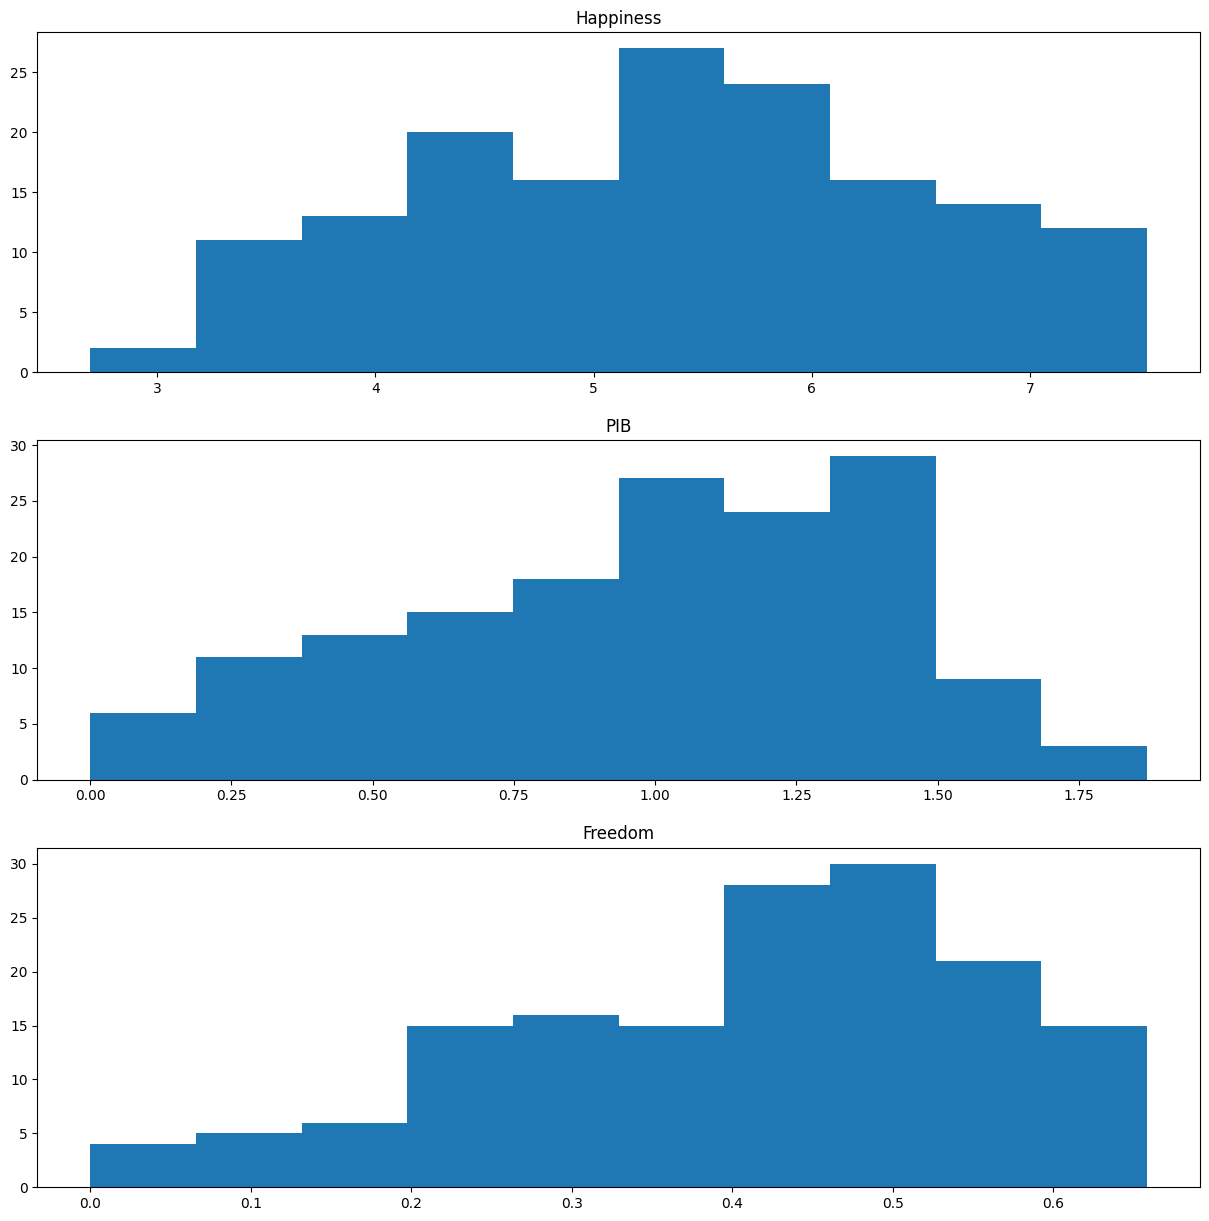

In [581]:
plotDataDistribution(world_happiness_v1)

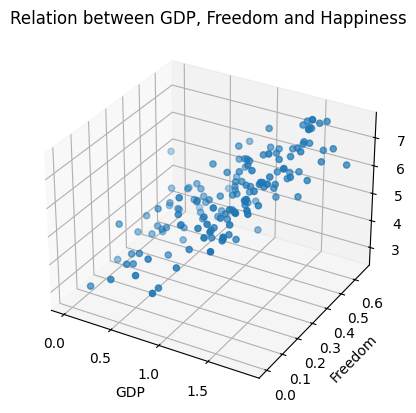

In [582]:
plotData(world_happiness_v1)

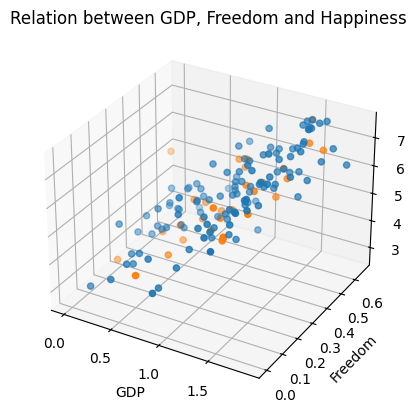

In [583]:
plotTrainingAndValidationDatas(world_happiness_v1)

In [584]:
regresor = getRegressor(world_happiness_v1)
w0, w1, w2 = regresor.intercept_, regresor.coef_[0], regresor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 2.6245071860568627 + 1.872766520520709*x1 + 2.244325331404894*x2


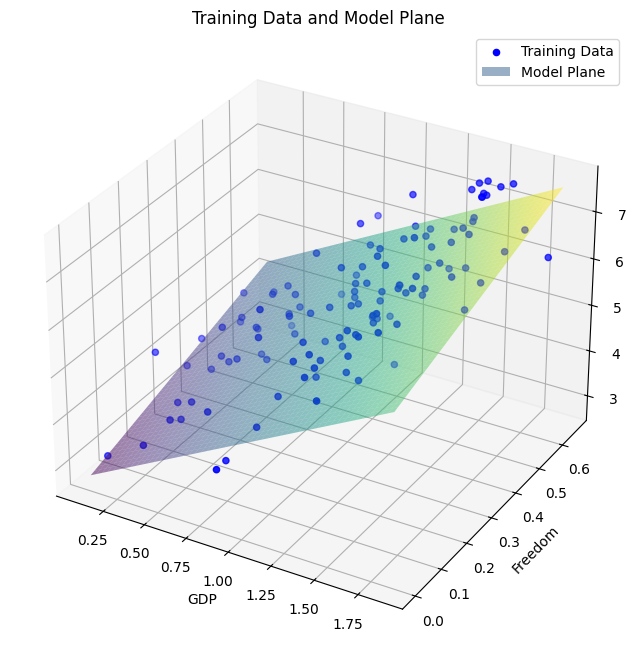

In [585]:
plotRegressor(world_happiness_v1)

In [586]:
mErr, cErr = getErrors(world_happiness_v1)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.3301055078292677
Computed error: 0.3301055078292677


## Problema 2

In [587]:
world_happiness_v2 = readDatas("datas/v2_world-happiness-report-2017.csv")


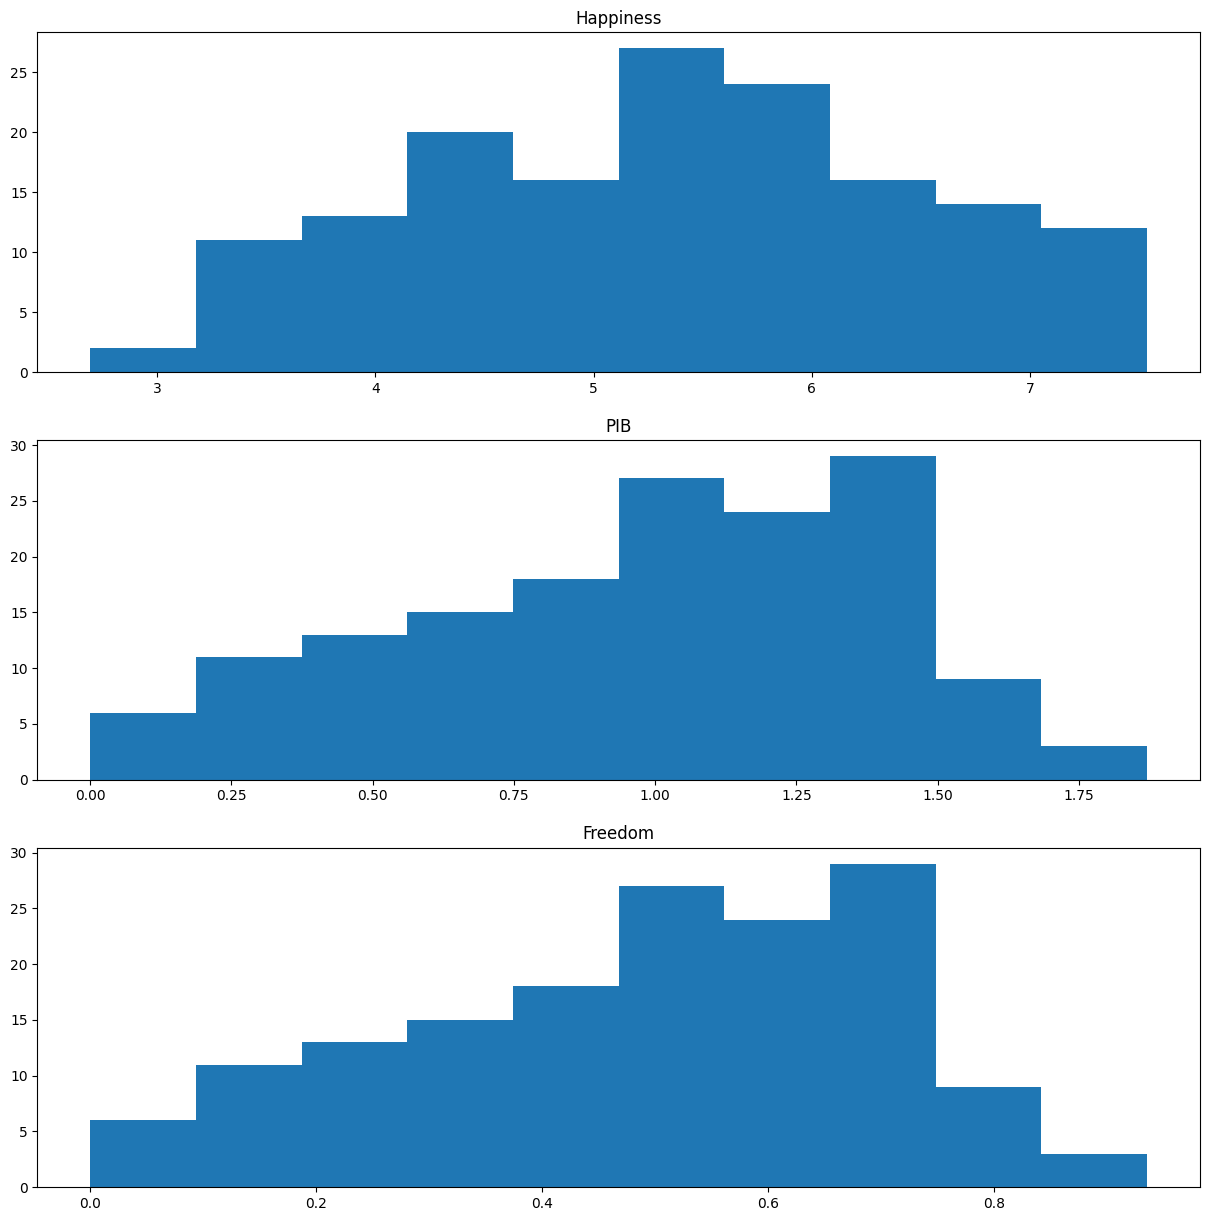

In [588]:
plotDataDistribution(world_happiness_v2)

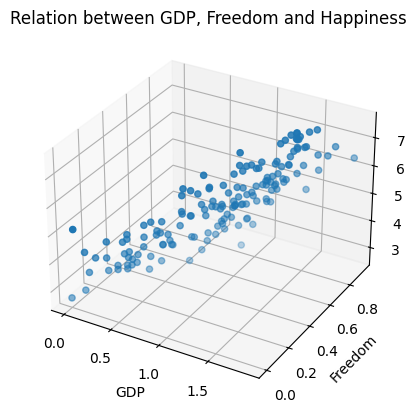

In [589]:
plotData(world_happiness_v2)

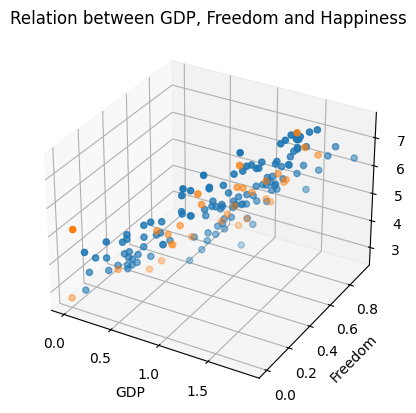

In [590]:
plotTrainingAndValidationDatas(world_happiness_v2)

In [591]:
regressor = getRegressor(world_happiness_v2)
w0, w1, w2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 3.2231305365286875 + -15595533.214266479*x1 + 31191070.829335317*x2


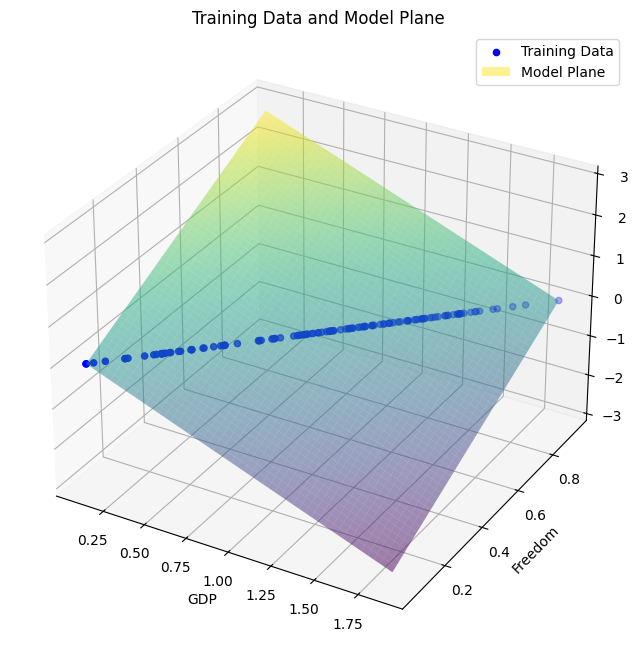

In [592]:
plotRegressor(world_happiness_v2)

In [593]:
mErr, cErr = getErrors(world_happiness_v2)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.48695426853082285
Computed error: 0.48695426853082285


## Problema 3

In [594]:
world_happiness_v3 = readDatas("datas/v3_world-happiness-report-2017.csv")

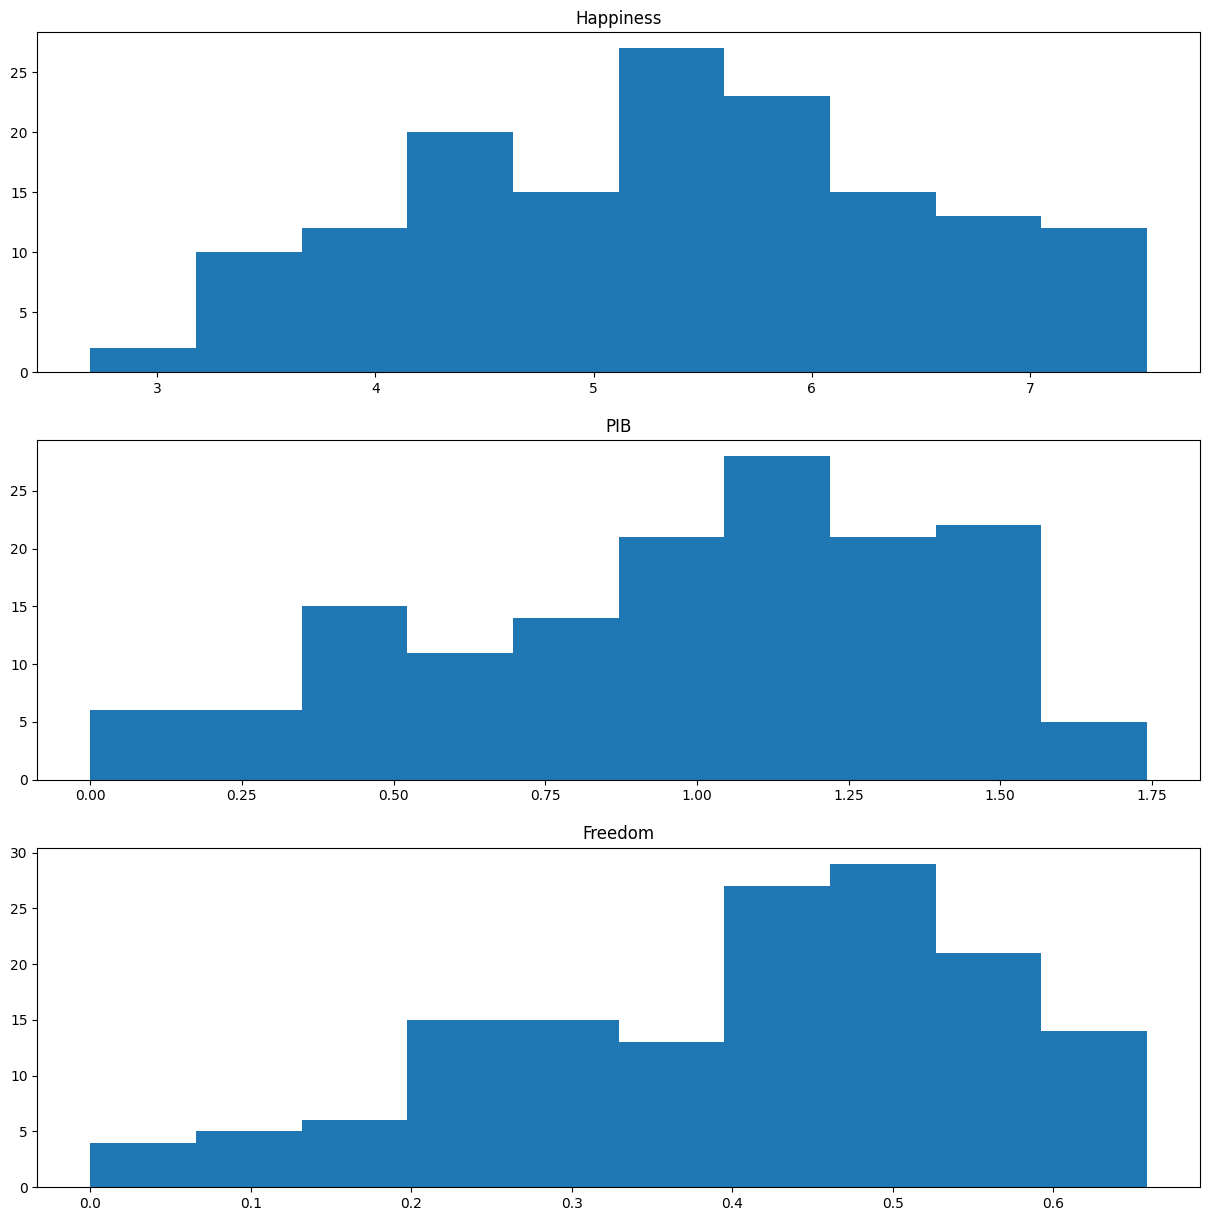

In [595]:
plotDataDistribution(world_happiness_v3)

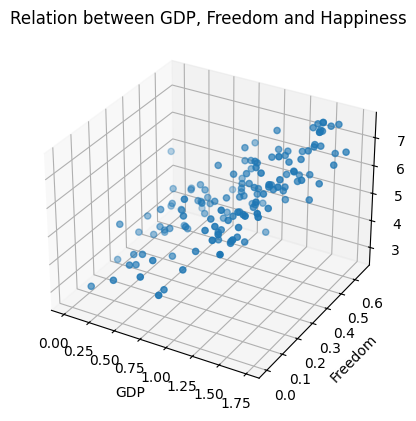

In [596]:
plotData(world_happiness_v3)

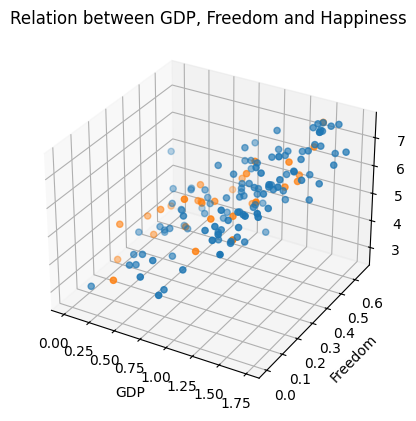

In [597]:
plotTrainingAndValidationDatas(world_happiness_v3)

In [598]:
regresor = getRegressor(world_happiness_v3)
w0, w1, w2 = regresor.intercept_, regresor.coef_[0], regresor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 2.3934537236248437 + 1.8751447069298175*x1 + 2.7156915588397856*x2


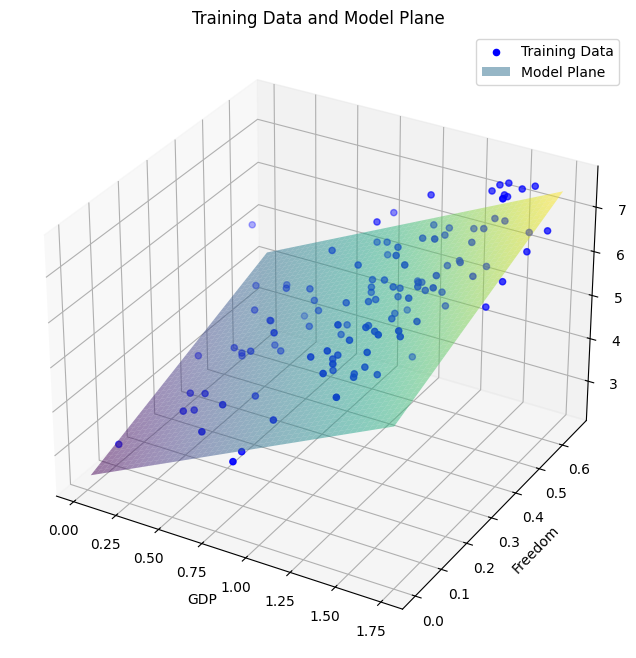

In [599]:
plotRegressor(world_happiness_v3)

In [600]:
mErr, cErr = getErrors(world_happiness_v3)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.34500580655745344
Computed error: 0.34500580655745355
